In [1]:
import torch
import torch.nn.functional as F
from helpers import char_to_int_map, int_to_char_map, build_dataset, split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class Linear:
    def __init__(self, fan_in, fan_out, g=torch.Generator(), bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # the sqrt(fan_in) comes from normalizing the layer
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [3]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim) # this is the gain
        self.beta = torch.zeros(dim) # this is the bias 
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        assert x.shape[1] == self.gamma.shape[0]
        
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        self.out = self.gamma * (x - xmean) / torch.sqrt(xvar + self.eps) + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]        

In [4]:
class Tanh:
    def __call__(self, x):        
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

In [5]:
words = open("names.txt").read().splitlines()
ctoi = char_to_int_map(start_char='.')
itoc = int_to_char_map(ctoi)
num_c = len(ctoi)
block_size = 3
X, Y = build_dataset(words, ctoi, block_size) 
vocab_size = len(ctoi)

In [6]:
# encoder = lambda x, num_c: F.one_hot(x, num_classes=num_c).float()
# encx, ency = encoder(X, vocab_size), encoder(Y, vocab_size) # you don't have to encode, since these are just popping out row that matches

In [7]:
X_train, X_val, X_test  = split(X, [0.8,0.1,0.1])
Y_train, Y_val, Y_test = split(Y, [0.8,0.1,0.1])

In [8]:
def init_no_bn(vocab_size, block_size, n_emb=10, n_hidden=100):
    g = torch.Generator().manual_seed(1234)

    C = torch.randn((vocab_size, n_emb), generator=g)
    layers = [
        Linear(block_size * n_emb, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden, vocab_size)
    ]

    with torch.no_grad():
        layers[-1].weight *= 0.1
        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= 5/3
    parameters = [C] + [p for layer in layers for p in layer.parameters()]
    print("num of parameters: ", sum(p.nelement() for p in parameters))
    for i, p in enumerate(parameters):
        p.requires_grad = True
    return C, layers, parameters

In [9]:
def train(C, layers, parameters, X, Y, max_steps=10, batch_size=32):
    lossi = []
    ud = []
    g = torch.Generator().manual_seed(1234)

    for i in tqdm(range(max_steps)):
        
        # make batch slice
        ix = torch.randint(0, X.shape[0], (batch_size, ), generator=g)
        # make batches
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        emb = C[Xb]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb)    
        # backward pass
        for layer in layers:
            layer.out.retain_grad()
        for p in parameters:
            p.grad = None
        loss.backward()
        for p in parameters:
            assert p.grad != None
        # update
        lr = 0.1 if i < 10e5 else 0.01 # one step lr decay
        for p in parameters:
            p.data += -lr * p.grad
            
        # stats
        lossi.append(loss.log10().item())    

        with torch.no_grad():
            ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # keeping track of the ratio of the update that will be applied in the next layer and the std of the data. So lr*grad / data
    return lossi, ud

In [27]:
def plot(layers=[], parameters=[], ud=[], lossi=[]):
    plt.figure(figsize=(20,4))
    legends = []
    for i, layer in enumerate(layers[:-1]):
        if isinstance(layer, Tanh):
            t = layer.out
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
    plt.title('activation dist')
    
    plt.figure(figsize=(20,4))
    legends = []
    for i, layer in enumerate(layers[:-1]):
        if isinstance(layer, Tanh):
            t = layer.out.grad
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
    plt.title('activation grad dist')
    
    plt.figure(figsize=(20,4))
    legends = []
    for i, p in enumerate(parameters):
        if p.ndim == 2:
            t = p.grad
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'param {i}')
    plt.legend(legends);
    plt.title('weight grad dist')
    
    plt.figure(figsize=(20,4))
    legends = []
    for i, p in enumerate(parameters): 
        if p.ndim == 2:
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append(f'param {i}')
    plt.plot([0, len(ud)], [-3,-3], 'k') # we would want our updates to converge to around 10e-3, which is 0.001, which indicates a lower change in the update, showing convergence
    plt.legend(legends);
    plt.title('udpate ratio')
    
    plt.figure(figsize=(20,4))
    legends = []
    plt.plot(range(len(lossi)), lossi)
    plt.legend(legends);
    plt.title('loss')

num of parameters:  36397


100%|██████████| 1000/1000 [00:00<00:00, 1279.87it/s]


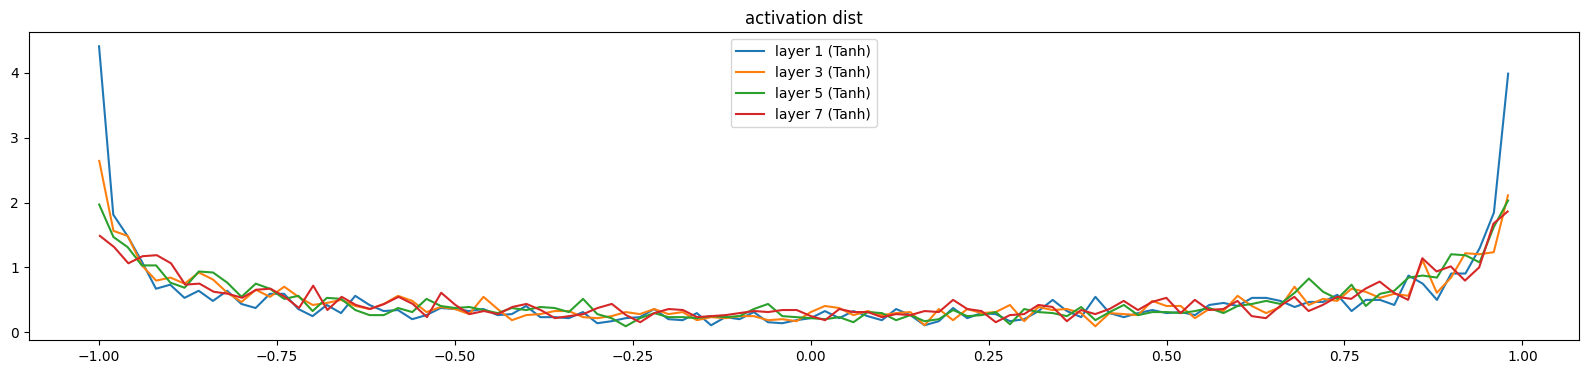

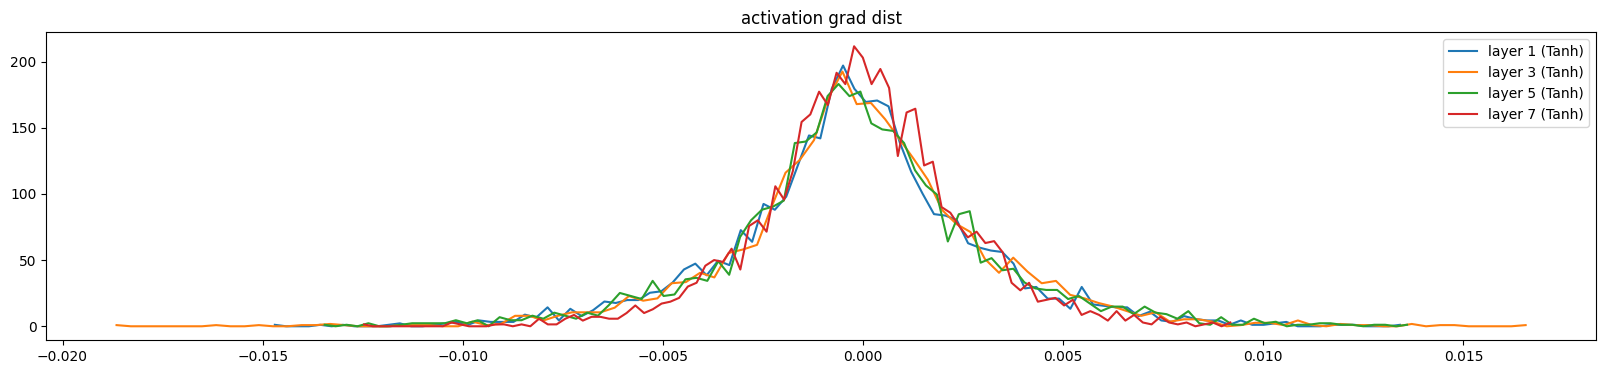

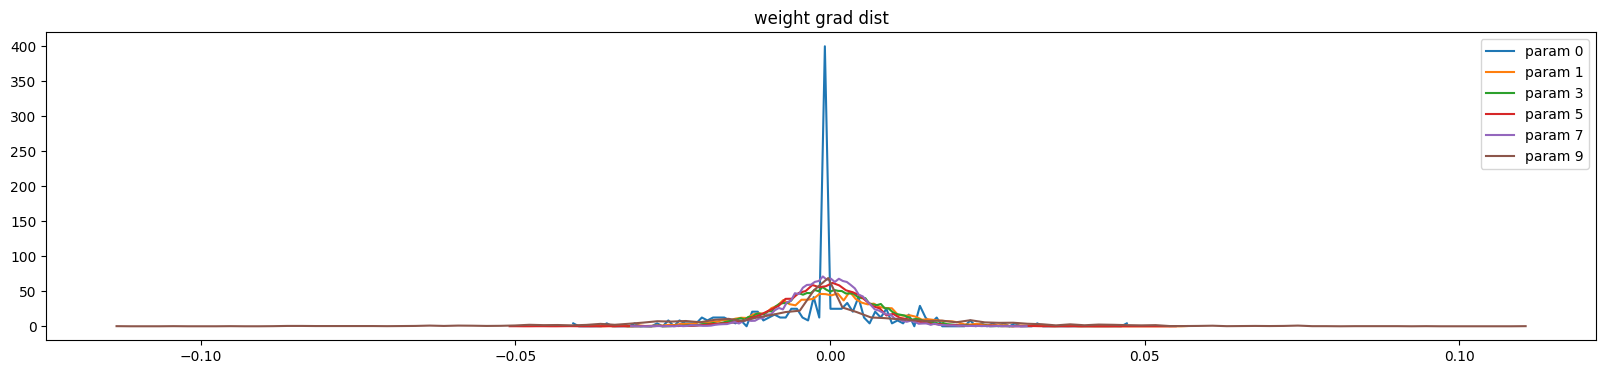

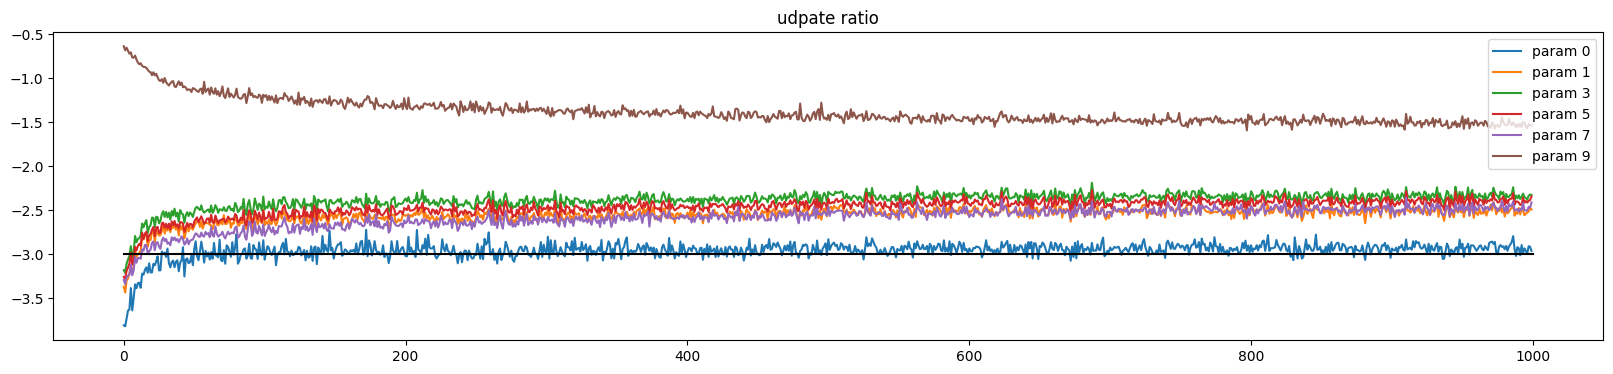

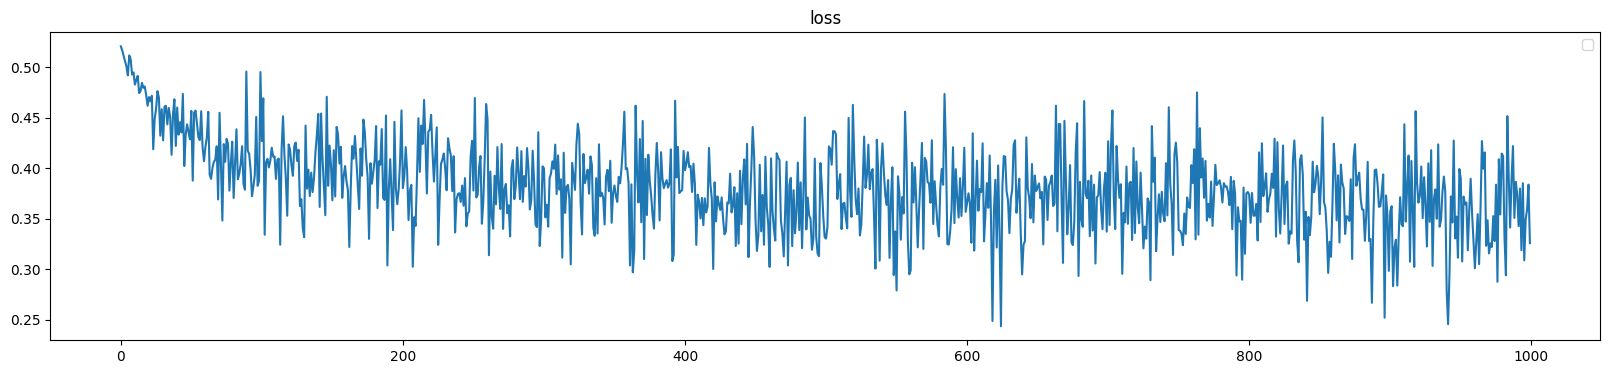

In [28]:
C, layers, parameters = init_no_bn(vocab_size, block_size, n_emb=10, n_hidden=100)
lossi, ud = train(C, layers, parameters, X_train, Y_train, max_steps=1000)
plot(layers, parameters, ud, lossi)

In [29]:
def init_bn(vocab_size, block_size, n_emb=10, n_hidden=100):
    g = torch.Generator().manual_seed(1234)

    C = torch.randn((vocab_size, n_emb), generator=g)
    layers = [
        Linear(block_size * n_emb, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, vocab_size)
    ]

    with torch.no_grad():
        layers[-1].weight *= 0.1
        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= 5/3
    parameters = [C] + [p for layer in layers for p in layer.parameters()]
    print("num of parameters: ", sum(p.nelement() for p in parameters))
    for i, p in enumerate(parameters):
        p.requires_grad = True
    return C, layers, parameters

num of parameters:  37197


100%|██████████| 10000/10000 [00:16<00:00, 622.41it/s]


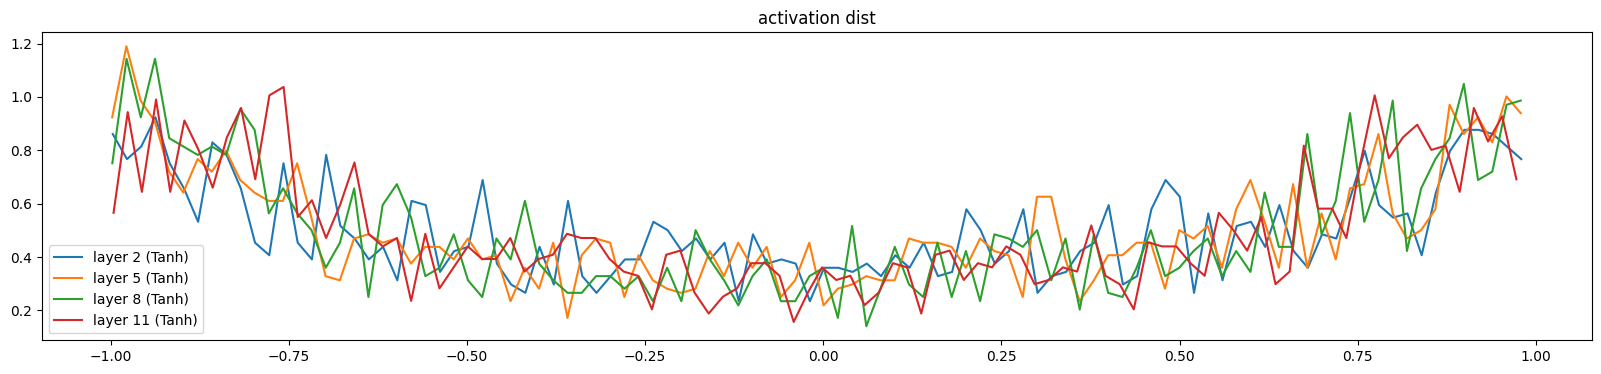

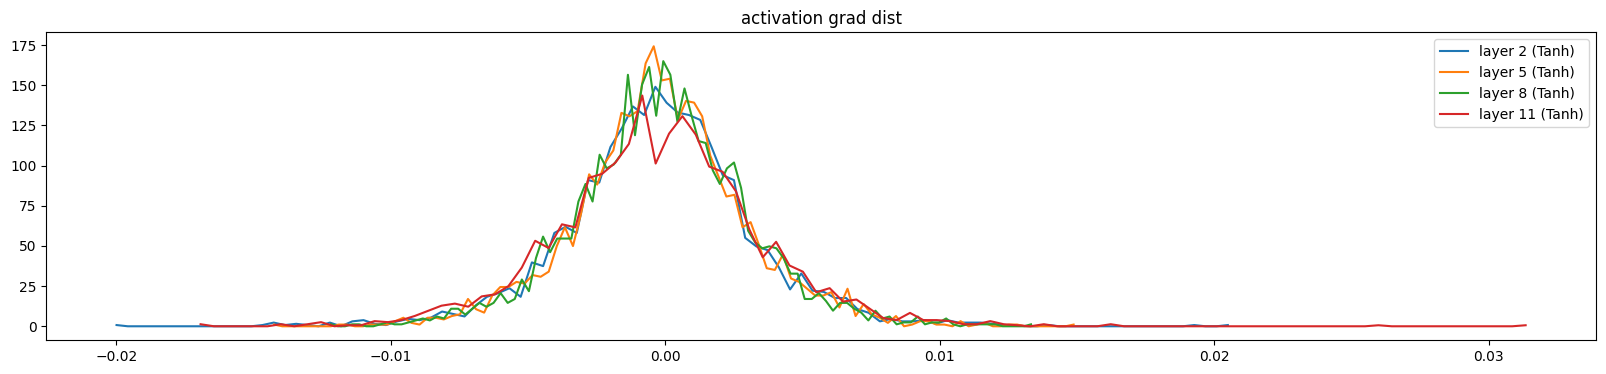

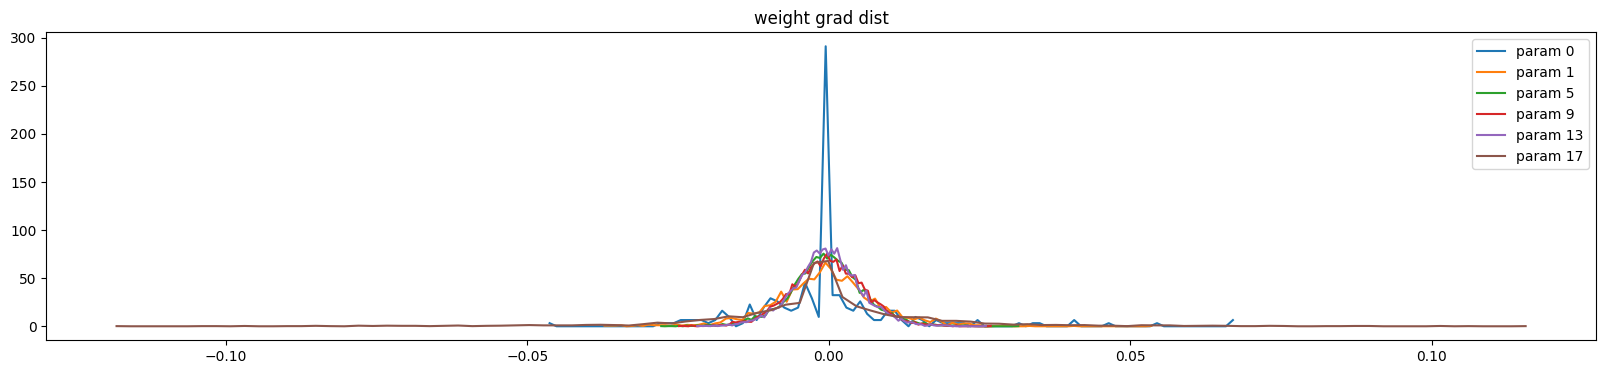

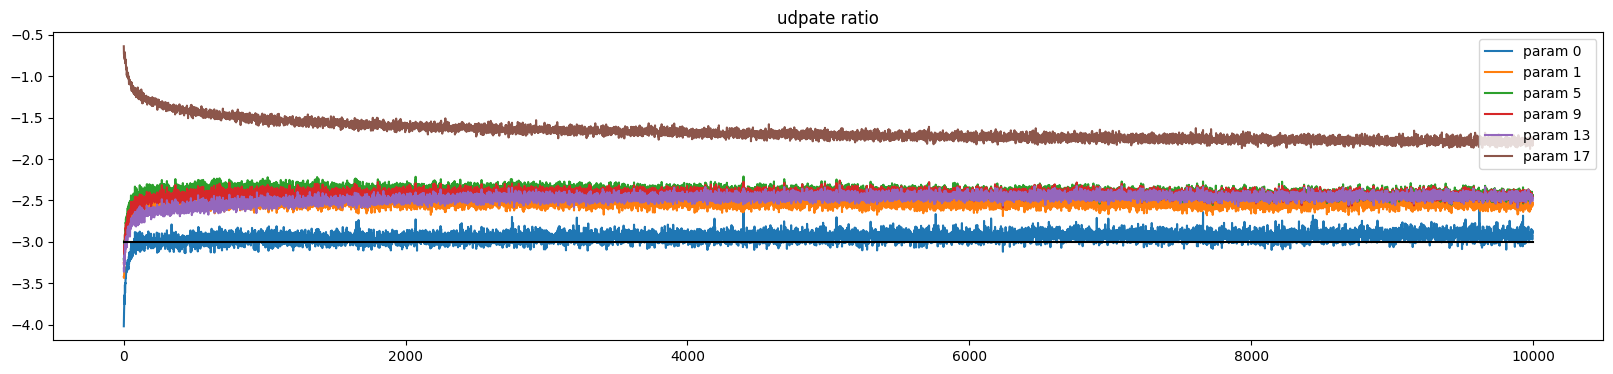

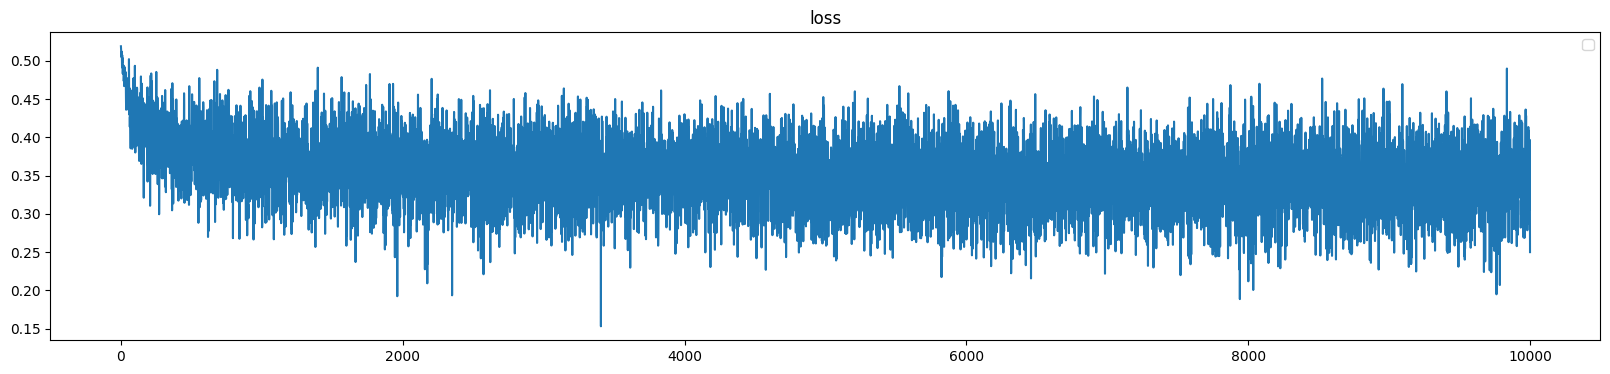

In [30]:
C_bn, layers_bn, parameters_bn = init_bn(vocab_size, block_size, n_emb=10, n_hidden=100)
lossi, ud = train(C_bn, layers_bn, parameters_bn, X_train, Y_train, max_steps=10000)
plot(layers_bn, parameters_bn, ud, lossi)